In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import stft
from pzData import pzNpz
from ezPzModels import ezPzLSTM

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("cuda")
else:
    device = torch.device('cpu')
    print("CPU")

cuda


In [3]:
device = torch.device('cpu')

In [11]:
train_labels = "./data/train_labels.csv"
# test_labels = "./data/test_labels.csv"
val_labels = "./data/val_labels.csv"
val_dir = test_dir = train_dir = "./data/raw/"

CROP = 15000
cut = lambda x: x[:CROP]

def stfourier(x):
    freq = len(x) // 3.0
    f, t, Zxx = stft(x[:, :CROP], fs=freq, nperseg=100, noverlap=50)
    return np.asarray([f, t, Zxx])

def fourier(x):
    t = x[0, 1000:CROP+1000]
    d = np.fft.fft(x[1, 1000:CROP+1000])
    return np.asarray([t, d])


train_dataset = pzNpz(train_labels, train_dir, transform=fourier)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

# test_dataset = pzNpz(test_labels, test_dir, transform=fourier)
# test_loader = DataLoader(test_dataset, batch_size=10)

val_dataset = pzNpz(val_labels, val_dir, transform=fourier)
val_loader = DataLoader(val_dataset, batch_size=10)

In [12]:
# model parameters
input_size = CROP
# for now, this is only a binary classification task
num_classes = 2

In [55]:
def train_lstm(hidden_size, num_layers, learning_rate, batch_size, dropout=0.0, optim=torch.optim.Adam, num_epochs=10, vis=False):

    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    model = ezPzLSTM(input_size, hidden_size, num_layers, num_classes, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []


    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, (x, y) in enumerate(train_loader):
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = criterion(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
        train_losses.append(running_loss / len(train_loader))

        model.eval()

        predicted_y = []
        true_y = []
        val_loss = 0
        with torch.no_grad():
            for val_x, val_y in val_loader:
                val_x = val_x.to(device=device, dtype=torch.float32)
                val_y = val_y.to(device=device, dtype=torch.long)
                val_scores = model(val_x)
                _, preds = torch.max(val_scores, 1)
                val_scores = model(val_x)
                val_loss += criterion(val_scores, val_y).item()

                if device != torch.device('cpu'):
                    predicted_y.extend(preds.cpu().numpy())
                    true_y.extend(val_y.cpu().numpy())
                else:
                    predicted_y.extend(preds.numpy())
                    true_y.extend(val_y.numpy())
            
            val_accuracy = accuracy_score(true_y, predicted_y)
            average_val_loss = val_loss / len(val_loader)
            val_losses.append(average_val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.5f}, Val Acc: {val_accuracy:.2%}")

    if vis:
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.ylim((0, 1.5))
        plt.legend()
        plt.show()

    del optim
    torch.cuda.empty_cache()
    
    return model, val_accuracy

In [56]:
param_grid = {
    'hidden_size': [64, 75],
    'num_layers': [4, 5],
    'learning_rate': [0.005, 0.007],
    'batch_size': [24, 16],
    'dropout': [0.2, 0.4],
    'optim': [torch.optim.RMSprop],
}
configs = {}

best_accuracy = 0.0
best_params = {}

for hidden_size in param_grid['hidden_size']:
    for num_layers in param_grid['num_layers']:
        for batch_size in param_grid['batch_size']:
            for dropout in param_grid['dropout']:
                for optim in param_grid['optim']:
                    for learning_rate in param_grid['learning_rate']:
                        # print(f"TRAINING ON: hidsize {hidden_size}, numlayers {num_layers}, learnrate {learning_rate}")
                        model, accuracy = train_lstm(hidden_size, num_layers, learning_rate, batch_size, dropout, optim)
                        print(f"ACCURACY {hidden_size}, {num_layers}, {learning_rate}, {batch_size}, {dropout}, {optim}:  {accuracy:.3%}")
                        configs[hidden_size, num_layers, learning_rate, batch_size, dropout, optim] = accuracy
                        if accuracy > best_accuracy:
                            if accuracy > .5:
                                torch.save(model, './saved_models/bin_lstm.pth')
                            best_accuracy = accuracy
                            best_params = {'hidden_size': hidden_size, 'num_layers': num_layers, 'learning_rate': learning_rate, 'batch_size': batch_size, 'dropout': dropout, 'optim': optim}

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

Epoch [1/10], Loss: 0.71551, Val Acc: 45.61%
Epoch [2/10], Loss: 0.69594, Val Acc: 45.61%
Epoch [3/10], Loss: 0.69080, Val Acc: 45.61%
Epoch [4/10], Loss: 0.67123, Val Acc: 54.39%
Epoch [5/10], Loss: 0.57892, Val Acc: 45.61%
Epoch [6/10], Loss: 0.40856, Val Acc: 40.35%
Epoch [7/10], Loss: 0.27600, Val Acc: 45.61%
Epoch [8/10], Loss: 0.15763, Val Acc: 47.37%
Epoch [9/10], Loss: 0.13162, Val Acc: 43.86%
Epoch [10/10], Loss: 0.11126, Val Acc: 45.61%
ACCURACY 64, 4, 0.005, 24, 0.2, <class 'torch.optim.rmsprop.RMSprop'>:  45.614%
Epoch [1/10], Loss: 0.78395, Val Acc: 45.61%
Epoch [2/10], Loss: 0.70000, Val Acc: 45.61%
Epoch [3/10], Loss: 0.69420, Val Acc: 45.61%
Epoch [4/10], Loss: 0.69329, Val Acc: 45.61%
Epoch [5/10], Loss: 0.69215, Val Acc: 45.61%
Epoch [6/10], Loss: 0.69249, Val Acc: 45.61%
Epoch [7/10], Loss: 0.66317, Val Acc: 45.61%
Epoch [8/10], Loss: 0.64415, Val Acc: 47.37%
Epoch [9/10], Loss: 0.52657, Val Acc: 57.89%
Epoch [10/10], Loss: 0.39020, Val Acc: 57.89%
ACCURACY 64, 4, 0.

In [57]:
avg_dr = {}
for dr in param_grid['dropout']:
    accs = [accuracy for (h, n, lr, b, d, o), accuracy in configs.items() if d == dr]
    avg_dr[dr] = sum(accs) / len(accs) if accs else 0.0

for dr, avg_acc in avg_dr.items():
    print(f"Average Accuracy for dropout {dr}: {avg_acc:.3%}")

Average Accuracy for dropout 0.2: 51.316%
Average Accuracy for dropout 0.4: 51.535%


In [58]:
avg_lr = {}
for lr in param_grid['learning_rate']:
    accs = [accuracy for (h, n, l, b, d, o), accuracy in configs.items() if l == lr]
    avg_lr[lr] = sum(accs) / len(accs) if accs else 0.0

for lr, avg_acc in avg_lr.items():
    print(f"Average Accuracy for learning_rate {lr}: {avg_acc:.3%}")

Average Accuracy for learning_rate 0.005: 50.877%
Average Accuracy for learning_rate 0.007: 51.974%


In [59]:
avg_hs = {}
for hs in param_grid['hidden_size']:
    accs = [accuracy for (h, n, l, b, d, o), accuracy in configs.items() if h == hs]
    avg_hs[hs] = sum(accs) / len(accs) if accs else 0.0

for hs, avg_acc in avg_hs.items():
    print(f"Average Accuracy for hidden_size {hs}: {avg_acc:.3%}")

Average Accuracy for hidden_size 64: 50.987%
Average Accuracy for hidden_size 75: 51.864%


In [64]:
avg_nl = {}
for nl in param_grid['num_layers']:
    accs = [accuracy for (h, n, l, b, d, o), accuracy in configs.items() if n == nl]
    avg_nl[nl] = sum(accs) / len(accs) if accs else 0.0

for nl, avg_acc in avg_nl.items():
    print(f"Average Accuracy for num_layers {nl}: {avg_acc:.3%}")

Average Accuracy for num_layers 4: 51.864%
Average Accuracy for num_layers 5: 50.987%


In [63]:
avg_bs = {}
for bs in param_grid['batch_size']:
    accs = [accuracy for (_, _, _, b, _, _), accuracy in configs.items() if b == bs]
    avg_bs[bs] = sum(accs) / len(accs) if accs else 0.0

for bs, avg_acc in avg_bs.items():
    print(f"Average Accuracy for batch_size {bs}: {avg_acc:.3%}")

Average Accuracy for batch_size 24: 51.425%
Average Accuracy for batch_size 16: 51.425%


In [61]:
avg_opt = {}
for opt in param_grid['optim']:
    accs = [accuracy for (_, _, _, _, _, o), accuracy in configs.items() if o == opt]
    avg_opt[opt] = sum(accs) / len(accs) if accs else 0.0

for opt, avg_acc in avg_opt.items():
    print(f"Average Accuracy for optimizer {opt}: {avg_acc:.3%}")

Average Accuracy for optimizer <class 'torch.optim.rmsprop.RMSprop'>: 51.425%


In [65]:
ezPiezo = ezPzLSTM
model = torch.load('./saved_models/bin_lstm.pth')
model.to(device).eval()
criterion = nn.CrossEntropyLoss()

predicted_y = []
true_y = []
val_loss = 0
with torch.no_grad():
    for val_x, val_y in val_loader:
        val_x = val_x.to(device=device, dtype=torch.float32)
        val_y = val_y.to(device=device, dtype=torch.long)
        val_scores = model(val_x)
        _, preds = torch.max(val_scores, 1)
        val_scores = model(val_x)
        val_loss += criterion(val_scores, val_y).item()

        if device == torch.device('cuda'):
            predicted_y.extend(preds.cpu().numpy())
            true_y.extend(val_y.cpu().numpy())
        else:
            predicted_y.extend(preds.numpy())
            true_y.extend(val_y.numpy())
    
    val_accuracy = accuracy_score(true_y, predicted_y)
    print(f'Validation Accuracy: {val_accuracy:.2%}')

    average_val_loss = val_loss / len(val_loader)
    print(f'Average Validation Loss: {average_val_loss:.3f}')

Validation Accuracy: 63.16%
Average Validation Loss: 1.026


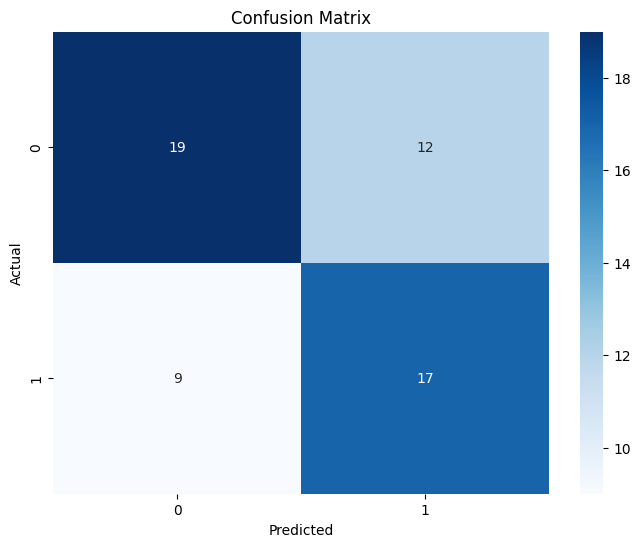

In [66]:
confusion = confusion_matrix(true_y, predicted_y)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Multi-class

In [70]:
train_m = "./data/train_multi.csv"
val_m = "./data/val_multi.csv"
data_dir = "./data/raw/"

CROP = 12000
cut = lambda x: x[:CROP]

def stfourier(x):
    freq = len(x) // 3.0
    f, t, Zxx = stft(x[:, :CROP], fs=freq, nperseg=100, noverlap=50)
    return np.asarray([f, t, Zxx])

def fourier(x):
    t = x[0, :CROP]
    d = np.fft.fft(x[1, :CROP])
    return np.asarray([t, d])


train_dataset = pzNpz(train_m, data_dir, transform=fourier)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

val_dataset = pzNpz(val_m, data_dir, transform=fourier)
val_loader = DataLoader(val_dataset, batch_size=10)

In [71]:
# model parameters
input_size = CROP
hidden_size = 128
num_layers = 2
# classes: Major, minor, Major 7, minor 7
num_classes = 4

Validation Accuracy: 14.29%
Average Validation Loss: 1.0263
Epoch [1/10], Loss: 1.47202
Validation Accuracy: 28.57%
Average Validation Loss: 1.0263
Epoch [2/10], Loss: 1.39686
Validation Accuracy: 33.33%
Average Validation Loss: 1.0263
Epoch [3/10], Loss: 1.38948
Validation Accuracy: 35.71%
Average Validation Loss: 1.0263
Epoch [4/10], Loss: 1.39631
Validation Accuracy: 37.14%
Average Validation Loss: 1.0263
Epoch [5/10], Loss: 1.39089
Validation Accuracy: 33.33%
Average Validation Loss: 1.0263
Epoch [6/10], Loss: 1.38989
Validation Accuracy: 34.69%
Average Validation Loss: 1.0263
Epoch [7/10], Loss: 1.39140
Validation Accuracy: 35.71%
Average Validation Loss: 1.0263
Epoch [8/10], Loss: 1.38717
Validation Accuracy: 36.51%
Average Validation Loss: 1.0263
Epoch [9/10], Loss: 1.38714
Validation Accuracy: 35.71%
Average Validation Loss: 1.0263
Epoch [10/10], Loss: 1.38994


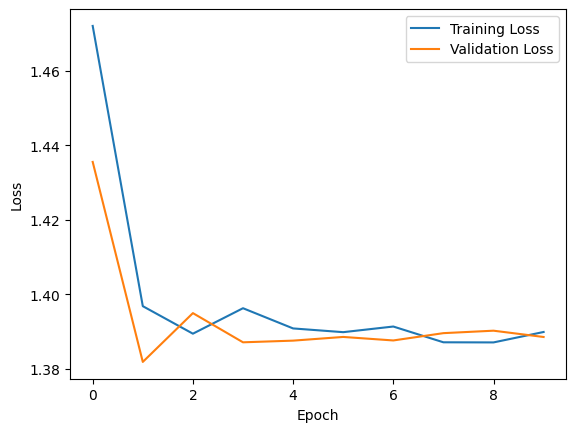

In [75]:
model = ezPzLSTM(input_size, 75, 5, num_classes, dropout=0.4)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.007)

num_epochs = 10

train_losses = []
val_losses = []
predicted_y = []
true_y = []

device = torch.device('cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (x, y) in enumerate(train_loader):
        x = x.to(device=device, dtype=torch.float32)
        y = y.to(device=device, dtype=torch.long)

        scores = model(x)
        loss = criterion(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    train_losses.append(running_loss / len(train_loader))

    model.eval()

    val_loss = 0
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x = val_x.to(device=device, dtype=torch.float32)
            val_y = val_y.to(device=device, dtype=torch.long)
            val_scores = model(val_x)
            _, preds = torch.max(val_scores, 1)
            val_scores = model(val_x)
            val_loss += criterion(val_scores, val_y).item()

        if device != torch.device('cpu'):
            predicted_y.extend(preds.cpu().numpy())
            true_y.extend(val_y.cpu().numpy())
        else:
            predicted_y.extend(preds.numpy())
            true_y.extend(val_y.numpy())
        
        val_accuracy = accuracy_score(true_y, predicted_y)
        print(f'Validation Accuracy: {val_accuracy:.2%}')

        avg_val_loss = val_loss / len(val_loader)
        print(f'Average Validation Loss: {average_val_loss:.4f}')

        val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.5f}")

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()